---
title: "Overschrijdingsfrequentielijnen"
execute:
  echo: false
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pydra_core as pydra

Als demonstratie worden overschrijdingsfrequentielijnen voor de Borselle (Westerschelde/Kust) bepaald. Hieronder definiëren we de locatie van de database.

In [2]:
DB_PATH = "data/WBI2017_Westerschelde_30-4_v03.sqlite"

<h3>HRDatabase</h3>

Met de HR database maken we een <i>HRDatabase</i> aan. Dit object beheert alle locaties in de HR database en helpt om batch berekeningen te maken.

In [3]:
hrdatabase = pydra.HRDatabase(DB_PATH)

Eén van de functies van een <i>HRDatabase</i> object is het uitlezen van de namen van alle uitvoerpunten.

In [4]:
hrdatabase.get_location_names()

['WS_1_30-4_dk_00006',
 'WS_2_30-4_dk_00005',
 'WS_1_30-4_dk_00004',
 'WS_1_30-4_dk_00003',
 'WS_1_30-4_dk_00002',
 'WS_1_30-4_dk_00001']

<h3>Settings</h3>

Met het <i>HRDatabase</i> maken we een <i>Settings</i> object aan voor het HR-uitvoerpunt 'WS_1_30-4_dk_00002'. Het <i>Settings</i> object is voor Pydra hetzelfde als het 'invoer.hyd' bestand voor Hydra-NL is.

In [5]:
settings = hrdatabase.get_settings("WS_1_30-4_dk_00002")

De settings zijn gebaseerd op wat standaard in Hydra-NL (versie 2.8.2) zit. Het is mogelijk om alle settings uit te lezen door het <i>Settings</i> object te printen.

In [6]:
print(settings)

database_path                  = data/WBI2017_Westerschelde_30-4_v03.sqlite
location                       = WS_1_30-4_dk_00002
m_max                          = 9.0
m_step                         = 0.1
model_uncertainty_water_level_steps = 7
model_uncertainty_wave_height_steps = 5
model_uncertainty_wave_period_steps = 5
periods_block_duration         = 360.0
region                         = 5.0
sea                            = 11.0
sea_level_probability_point1   = Zeewaterstand\Vlissingen\CondPovVlissingen_12u_zichtjaar2017_metOnzHeid.txt
sea_level_probability_point2   = Zeewaterstand\Hansweert\CondPovHansweert_12u_zichtjaar2017_metOnzHeid.txt
sea_level_probability_point3   = Zeewaterstand\Vlissingen virtueel\CondPovVlissingen-Additional_12u_zichtjaar2017_metOnzHeid.txt
sea_level_rise                 = 0.0
sigma_function                 = Sigmafunctie\Westerschelde\VS_sigmafunctie_WS_2017.txt
u_max                          = 55.0
u_repair                       = True
u_step            

Voordat berekeningen worden gedaan is het mogelijk om het <i>Settings</i> object aan te passen:

In [7]:
print("Origineel:", settings.m_max)
settings.m_max = 10.0
print("Aangepast:", settings.m_max)

Origineel: 9.0
Aangepast: 10.0


<h3>Location</h3>

Wanneer je tevreden bent met de settings in het <i>Settings</i> object, kan een <i>Location</i> object worden aangemaakt. Wanneer een location wordt aangemaakt lees Pydra de statistiek in en worden belastingsmodellen gegenereert. De statistiek wordt ingelezen vanuit de <i>data/statistics</i> map in de package. De belastingsmodellen worden geïnitieerd op basis van de eerder gekoppelde HR database in het <i>HRDatabase</i> object.

In [8]:
import warnings

warnings.filterwarnings("ignore")  # future warnings are annoying
location = hrdatabase.create_location(settings)
# TODO: deze error beter afvangen:

ERROR: Execution failed on sql '
                    SELECT ucf.HRDLocationId, ucf.ClosingSituationId, hrv.ResultVariableId, ucf.HRDResultColumnId2, ucf.Correlation
                    FROM UncertaintyCorrelationFactor ucf
                    INNER JOIN HRDResultVariables hrv
                    ON ucf.HRDResultColumnId = hrv.HRDResultColumnId
                    WHERE ucf.HRDLocationId = 146
                    ': no such table: UncertaintyCorrelationFactor, continuing without correlation


Nu het <i>Location</i> object is aangemaakt voor het HR uitvoerpunt 'WS_1_30-4_dk_00002', kan deze gebruikt worden in berekeningen.

<h3>Overschrijdingsfrequentielijn voor één uitvoerpunt</h3>

Pydra heeft verschillende rekenmodules (objecten). Hieronder gebruiken we de <i>ExceedanceFrequencyLine</i> module om de overschrijdingsfrequentielijn te berekenen. Voordat we dat kunnen doen moet eerst een rekenobject worden aangemaakt, hieronder <i>fl</i>. Het rekenobject omvat de instellingen voor de berekening, bijvoorbeeld voor welke variabel een frequentielijn moet worden berekend (hieronder waterstand (h)). Daarnaast zijn er nog een aantal optionele opties, zoals of er met modelonzekerheden moet worden gerekend (standaard : True), de stapgrootte van de frequentielijn (standaard : 0.05) en een aangepast bereik van waterstanden voor de frequentielijn (standaard tussen de 1ste en 99de percentiel vanuit de HR database).

In [9]:
fl = pydra.ExceedanceFrequencyLine("h", model_uncertainty=False)

Vervolgens kunnen we met het rekenobject <i>fl</i> een overschrijdingsfrequentielijn bepalen voor HR uitvoerpunt 'WS_1_30-4_dk_00002' door de <i>calculate()</i> functie aan te roepen van het rekenobject en het <i>location</i> object als argument mee te geven.

In [10]:
frequency_line = fl.calculate(location)

Dit geeft een overschrijdingsfrequentielijn <i>frequency_line</i>. Het is een object waarin de berekende gegevens (waterstanden en overschrijdingsfrequenties) worden opgeslagen. Als je het object print, zie je wat er allemaal in zit.

In [11]:
print(frequency_line)

FrequencyLine(level=array([ 4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,
        5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,
        6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,
        7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,
        8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,
        9.5,  9.6,  9.7,  9.8,  9.9, 10. ]), exceedance_frequency=array([9.94146683e-02, 6.72207910e-02, 4.56219043e-02, 3.10054478e-02,
       2.10762468e-02, 1.43146413e-02, 9.71920422e-03, 6.61635072e-03,
       4.52069251e-03, 3.09403250e-03, 2.11855920e-03, 1.45101223e-03,
       9.94944663e-04, 6.84217303e-04, 4.72480175e-04, 3.27514920e-04,
       2.27672043e-04, 1.58622527e-04, 1.10775309e-04, 7.75910268e-05,
       5.45422174e-05, 3.84913448e-05, 2.72802869e-05, 1.94117645e-05,
       1.38561679e-05, 9.91612413e-06, 7.11218042e-06, 5.11145157e-06,
       3.67977424e-06, 2.65317740e-06, 1.91566316e-0

Hieronder is een plot van de berekende overschrijdingsfrequentielijn gegeven.

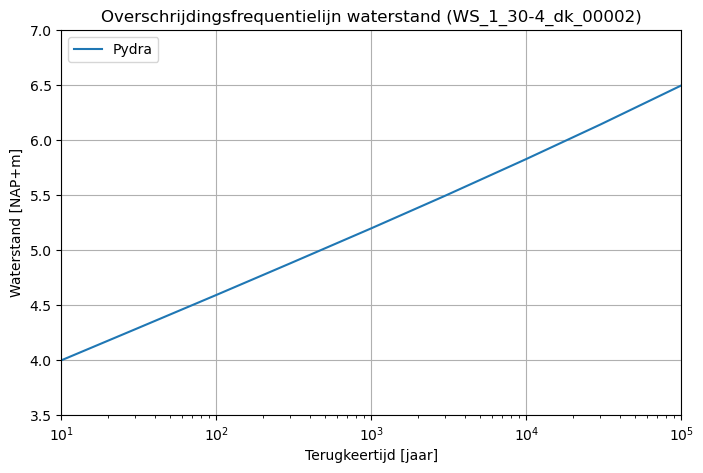

In [12]:
tt = np.array([10, 30, 100, 300, 1_000, 3_000, 10_000, 30_000, 100_000])

plt.figure(figsize=[8, 5])
plt.grid()
plt.plot(tt, frequency_line.interpolate_exceedance_probability(1 / tt), label="Pydra")
plt.legend(loc="upper left")
plt.title("Overschrijdingsfrequentielijn waterstand (WS_1_30-4_dk_00002)")
plt.xscale("log")
plt.xticks([10, 100, 1_000, 10_000, 100_000])
plt.xlabel("Terugkeertijd [jaar]")
plt.xlim(10, 100_000)
plt.ylabel("Waterstand [NAP+m]")
plt.ylim(3.5, 7.0)
plt.show()

We hebben dezelfde berekening gemaakt met Hydra-NL, wat de onderstaande vergelijking geeft.

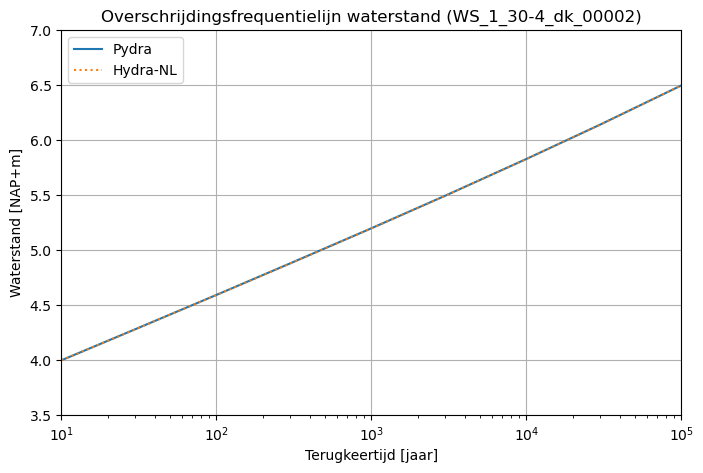

In [13]:
hydranl_h = [3.998, 4.28, 4.592, 4.879, 5.198, 5.494, 5.828, 6.141, 6.497]

plt.figure(figsize=[8, 5])
plt.grid()
plt.plot(tt, frequency_line.interpolate_exceedance_probability(1 / tt), label="Pydra")
plt.plot(tt, hydranl_h, ":", label="Hydra-NL")
plt.legend(loc="upper left")
plt.title("Overschrijdingsfrequentielijn waterstand (WS_1_30-4_dk_00002)")
plt.xscale("log")
plt.xticks([1, 10, 100, 1_000, 10_000, 100_000, 1_000_000])
plt.xlabel("Terugkeertijd [jaar]")
plt.xlim(10, 100_000)
plt.ylabel("Waterstand [NAP+m]")
plt.ylim(3.5, 7.0)
plt.show()

<h3>Overschrijdingsfrequentielijn voor een heel traject</h3>

Het is ook mogelijk om overschrijdingsfrequentielijnen voor een heel traject te genereren. Laten we weer een rekenobject <i>fl</i> aanmaken. Merk op dat we  ten opzichte van hierboven dit maal <i>model_uncertainty = False</i> hebben toegevoegd. Dit betekent dat we nu <u>zonder</u> modelonzekerheden rekenen.

In [14]:
fl = pydra.ExceedanceFrequencyLine("hs", model_uncertainty=False)

Door het <i>HRDatabase</i> object '<i>hrdatabase</i>' mee te geven als argument in de <i>calculate()</i> functie, bepaald Pydra de overschrijdingsfrequentielijn voor <u>alle</u> uitvoerpunten in de HR database. Voor locaties die al zijn gedefinieerd, zoals 'WS_1_30-4_dk_00002', wordt het eerder gedefinieerde <i>Location</i> object gebruikt. Voor uitvoerpunten die nog niet zijn gedefinieerd creëert Pydra automatisch een <i>Location</i> object met de standaardwaarden voor het water systeem (net zoals Hydra-NL een 'invoer.hyd' aanmaakt in de beoordelingsmodus).

Merk op dat dus in dit geval voor uitvoerpunt 'WS_1_30-4_dk_00002' met een <i>mmax</i> van NAP+10,0m wordt gerekend omdat we die eerder hebben aangepast. Voor de overige locaties wordt met de standaard NAP+9,0m gerekend.

In [15]:
freq_lines = fl.calculate(hrdatabase)
# TODO: deze errors beter afvangen:

ERROR: Execution failed on sql '
                    SELECT ucf.HRDLocationId, ucf.ClosingSituationId, hrv.ResultVariableId, ucf.HRDResultColumnId2, ucf.Correlation
                    FROM UncertaintyCorrelationFactor ucf
                    INNER JOIN HRDResultVariables hrv
                    ON ucf.HRDResultColumnId = hrv.HRDResultColumnId
                    WHERE ucf.HRDLocationId = 142
                    ': no such table: UncertaintyCorrelationFactor, continuing without correlation
ERROR: Execution failed on sql '
                    SELECT ucf.HRDLocationId, ucf.ClosingSituationId, hrv.ResultVariableId, ucf.HRDResultColumnId2, ucf.Correlation
                    FROM UncertaintyCorrelationFactor ucf
                    INNER JOIN HRDResultVariables hrv
                    ON ucf.HRDResultColumnId = hrv.HRDResultColumnId
                    WHERE ucf.HRDLocationId = 143
                    ': no such table: UncertaintyCorrelationFactor, continuing without correlation
ERROR: Exe

Omdat we nu een heel traject doorrekenen, zal <i>calculate()</i> niet één frequentielijn returnen. In plaats daarvan wordt een dictionary gereturnd met als key de naam van het uitvoerpunt en als value het <i>FrequencyLine</i> resultaat object.

In [16]:
print(freq_lines["WS_1_30-4_dk_00006"])

FrequencyLine(level=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8]), exceedance_frequency=array([3.59999446e+02, 2.11103636e+02, 6.37386524e+01, 1.48868762e+01,
       3.91035647e+00, 1.47486378e+00, 6.43080232e-01, 3.03598564e-01,
       1.36933737e-01, 6.66240482e-02, 3.15949196e-02, 1.51863801e-02,
       7.50939395e-03, 3.67264045e-03, 1.82304738e-03, 9.40031439e-04,
       5.08985734e-04, 2.68976473e-04, 1.46097359e-04, 8.15615499e-05,
       4.62984519e-05, 2.61301581e-05, 1.53889918e-05, 8.80943678e-06,
       5.17749562e-06, 3.00626056e-06, 1.87503263e-06, 1.16560449e-06,
       7.17687221e-07, 4.39546539e-07, 2.90961345e-07, 1.80292060e-07,
       1.20956989e-07, 8.01031566e-08, 5.11561637e-08, 3.30546245e-08,
       2.19297425e-08, 1.48800474e-08, 9.97659224e-09]))


Een overzicht van alle resultaten:

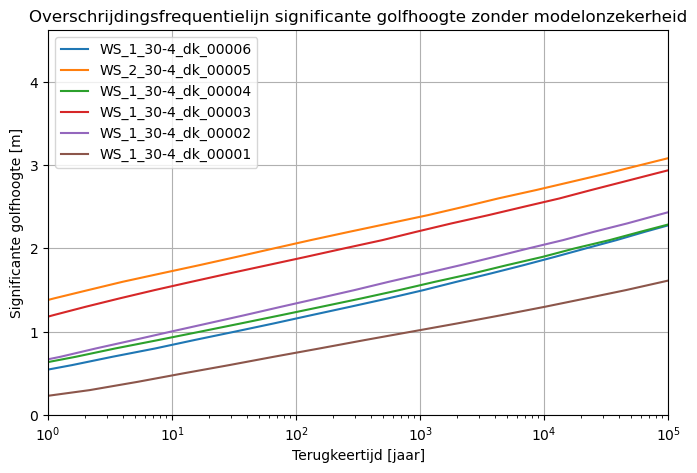

In [17]:
plt.figure(figsize=[8, 5])
plt.grid()

for _loc in freq_lines:
    plt.plot(
        1 / freq_lines[_loc].exceedance_frequency, freq_lines[_loc].level, label=_loc
    )

plt.legend(loc="upper left")
plt.title(
    "Overschrijdingsfrequentielijn significante golfhoogte zonder modelonzekerheid"
)
plt.xscale("log")
plt.xticks([1, 10, 100, 1_000, 10_000, 100_000])
plt.xlabel("Terugkeertijd [jaar]")
plt.xlim(1, 100_000)
plt.ylabel("Significante golfhoogte [m]")
plt.ylim(0, None)
plt.show()